In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# load modules:

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# custom modules
import modules.pre_processing_mdb
import modules.stl_trend_seasonality

import modules.ols_assumptions_check 
import modules.model_comparison

In [3]:
# Instantiate class:
pre_p = modules.pre_processing_mdb.PreProcessing()

In [4]:
df1 = pd.read_csv('s3a://dsaa-cph-ai-s3-dev/jan_rathfelder/fr_eyl_mdb.csv')
df2 = pd.read_csv('s3a://dsaa-cph-ai-s3-dev/jan_rathfelder/it_eyl_mdb.csv')
df3 = pd.read_csv('s3a://dsaa-cph-ai-s3-dev/jan_rathfelder/uk_eyl_mdb.csv')

mdb = pd.concat([df1,df2,df3])

In [5]:
mdb = pre_p.create_date_format(df=mdb,
                               original_date_column='yrmo') # Create datetime object yyyymm

mdb = pre_p.time_index(date='yyyymm', 
                       df=mdb)

### Data visualization

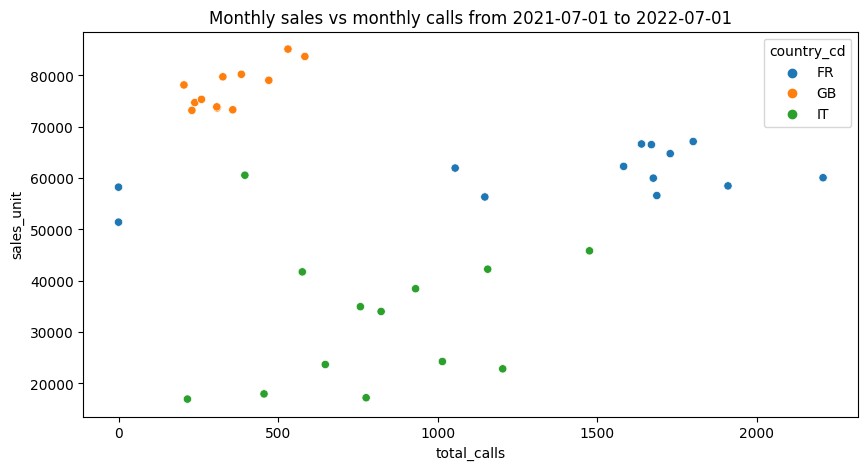

In [6]:
# monthly sales vs calls:

df = mdb[(mdb.yyyymm>='2021-07-01')&(mdb.yyyymm<='2022-07-01')].groupby(['yyyymm', 'country_cd'])[['total_calls','total_calls_cph','ae_nl_open', 'sales_unit']].sum().reset_index()

plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x="total_calls", y="sales_unit", hue="country_cd")
plt.title('Monthly sales vs monthly calls from 2021-07-01 to 2022-07-01')
plt.show()

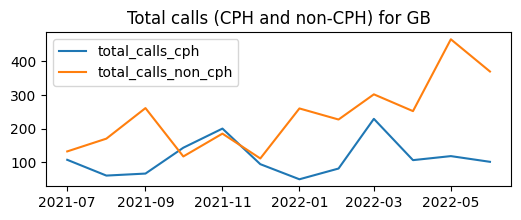

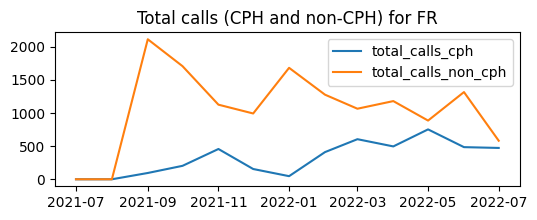

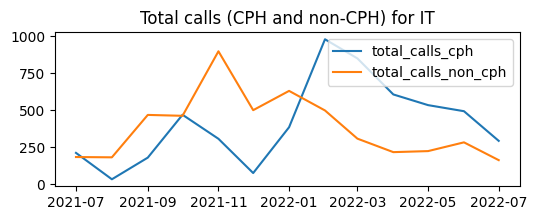

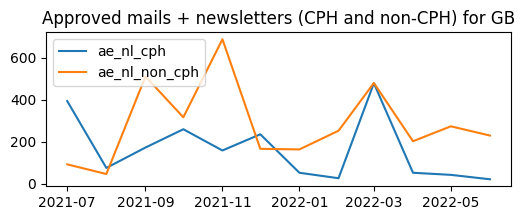

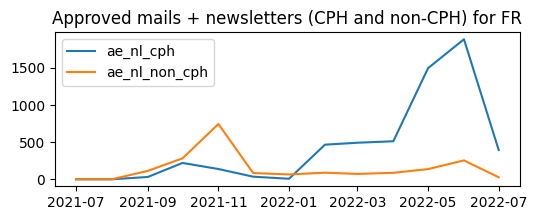

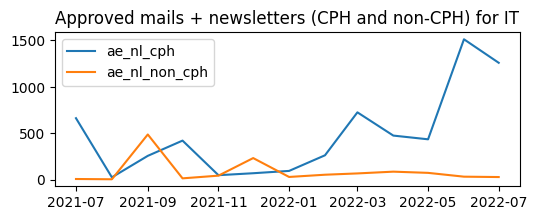

In [7]:
# Plot aggregated CPH and non-CPH actions:

df = mdb.groupby(['yyyymm','country_cd'])[['total_calls',
                                           'total_calls_cph',
                                           'total_calls_non_cph',
                                           'ae_nl_open', 
                                           'ae_nl_open_non_cph',
                                           'ae_nl_open_cph',
                                           'sales_unit']].sum().reset_index()

for idx in df.country_cd.unique():
    plt.figure(figsize=(6,2))
    plt.plot(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].yyyymm,
            df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].total_calls_cph,
            label='total_calls_cph')
    plt.plot(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].yyyymm,
             df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].total_calls_non_cph,
             label='total_calls_non_cph')
    plt.legend()
    plt.title('Total calls (CPH and non-CPH) for '+idx)
    plt.show()
    
for idx in df.country_cd.unique():
    plt.figure(figsize=(6,2))
    plt.plot(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].yyyymm,
            df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].ae_nl_open_cph,
            label='ae_nl_cph')
    plt.plot(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].yyyymm,
             df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].ae_nl_open_non_cph,
             label='ae_nl_non_cph')
    plt.legend()
    plt.title('Approved mails + newsletters (CPH and non-CPH) for '+idx)
    plt.show()

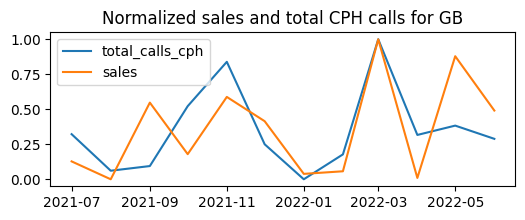

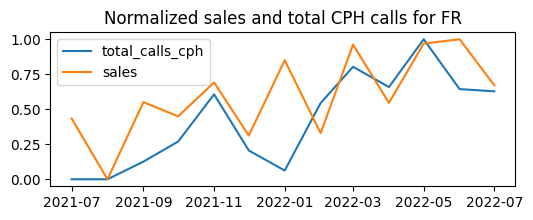

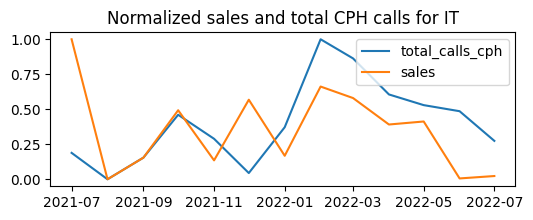

In [8]:
# Plot aggregated and normalized sales and CPH calls:

scaler = MinMaxScaler()

df = mdb.groupby(['yyyymm','country_cd'])[['total_calls','total_calls_cph','ae_nl_open', 'sales_unit']].sum().reset_index()

for idx in df.country_cd.unique():
    plt.figure(figsize=(6,2))
    plt.plot(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].yyyymm,
             scaler.fit_transform(np.array(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].total_calls_cph).reshape(-1,1)),
            label='total_calls_cph')
    plt.plot(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].yyyymm,
             scaler.fit_transform(np.array(df[(df.country_cd==idx)&(df.yyyymm>='2021-07-01')&(df.yyyymm<='2022-07-01')].sales_unit).reshape(-1,1)),
            label='sales')
    plt.legend()
    plt.title('Normalized sales and total CPH calls for '+idx)
    plt.show()

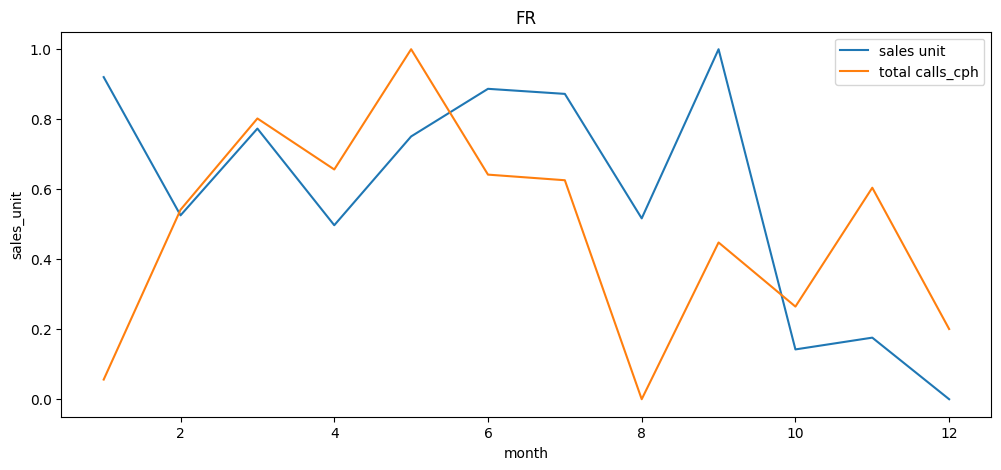

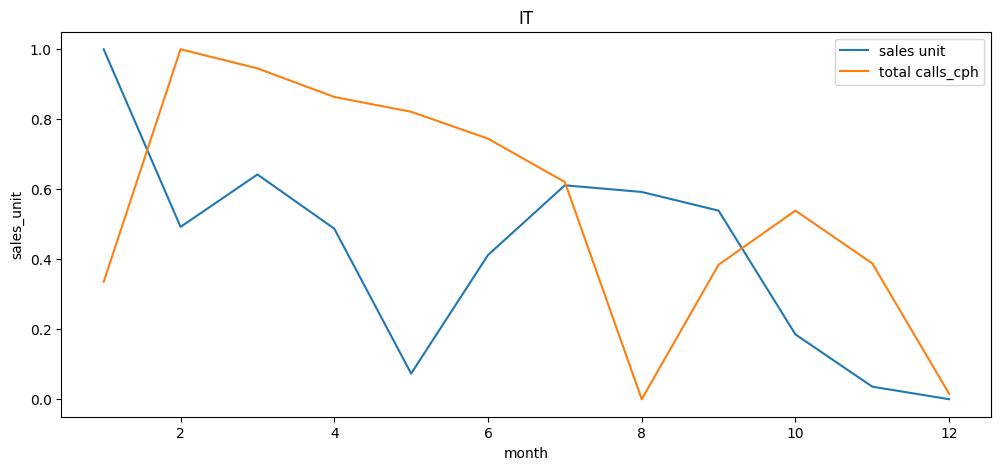

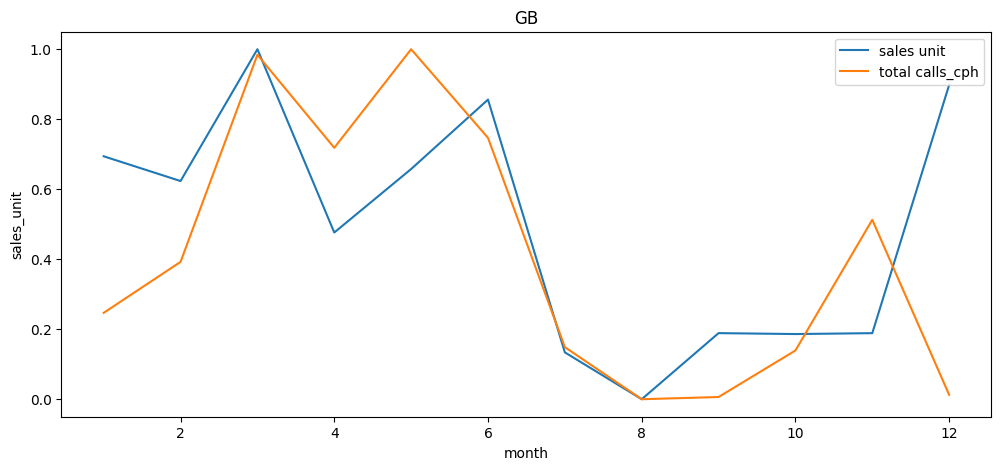

In [9]:
# Aggregate CPH-calls and sales by month to view monthly seasonality pattern:

scaler = MinMaxScaler()

for ctr in mdb.country_cd.unique():
    df = mdb[mdb.country_cd==ctr].groupby(['month'])[['total_calls','total_calls_cph','ae_nl_open', 'sales_unit']].sum().reset_index()

    df['total_calls_cph'] = scaler.fit_transform(np.array([df.total_calls_cph]).reshape(-1, 1))
    df['sales_unit'] = scaler.fit_transform(np.array([df.sales_unit]).reshape(-1, 1))

    plt.figure(figsize=(12,5))
    sns.lineplot(data=df, x="month", y="sales_unit")
    sns.lineplot(data=df, x="month", y="total_calls_cph")
    plt.legend(['sales unit', 'total calls_cph'])
    plt.title(ctr)
    plt.show()

#### Apply STL decomposition

In [10]:
# Clean data before STL decomposition:

mdb = pre_p.remove_na(df=mdb,
                      variable='sales_unit',
                      grouping=['brand_nm','country_cd','cstmr_1_id'],
                      date='yyyymm',
                      min_date='2018-12-01',
                      max_date='2022-06-01')

mdb = pre_p.remove_zero(df=mdb, 
                        variable='sales_unit', 
                        grouping=['brand_nm','country_cd','cstmr_1_id'], 
                        date='yyyymm',
                        min_date='2021-05-01',
                        max_date='2022-06-01',
                        threshold=0)

In [12]:
# apply STL decomposition:
stl_decompose = modules.stl_trend_seasonality.stl_decomposition('cstmr_1_id','yyyymm')

frames = []
sales_variable = 'sales_unit'

for country in mdb.country_cd.unique():
    for brand in mdb.brand_nm.unique():
        print(country,brand)
        df = stl_decompose.decomposition(df=mdb.query("country_cd == '{}' and brand_nm == '{}'".format(country, brand)), 
                                         target_value=sales_variable)
        frames += [df]

mdb = pd.concat(frames)

FR Eylea


/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_value+'_trend_stl'] = np.concatenate(trend)
/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_value+'_season_stl'] = np.concatenate(seasonality)
/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:55: SettingWithCopyWarning: 
A

IT Eylea


/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_value+'_trend_stl'] = np.concatenate(trend)
/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_value+'_season_stl'] = np.concatenate(seasonality)
/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:55: SettingWithCopyWarning: 
A

GB Eylea


/home/jan_rathfelder/Development/env_basic/lib/python3.9/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_value+'_trend_stl'] = np.concatenate(trend)
/home/jan_rathfelder/Development/dsci-janrth/cph_impact/modules/stl_trend_seasonality.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

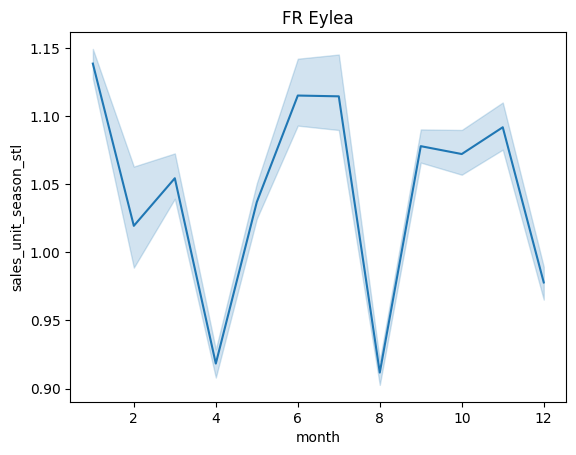

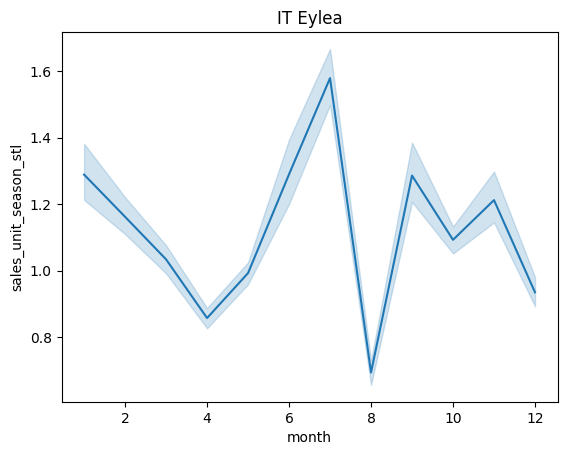

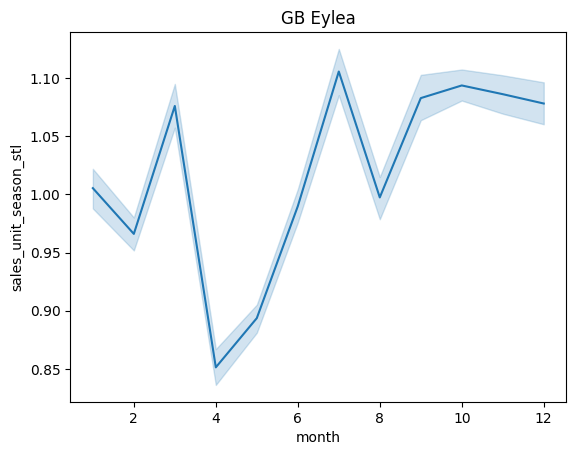

In [13]:
# plot seasonality

for country in mdb.country_cd.unique():
    for brand in mdb.brand_nm.unique():
        sns.lineplot(data=mdb[(mdb.country_cd==country)&
                              (mdb.brand_nm==brand)], x="month", y="sales_unit_season_stl")
        plt.title(country+' '+brand)
        plt.show()

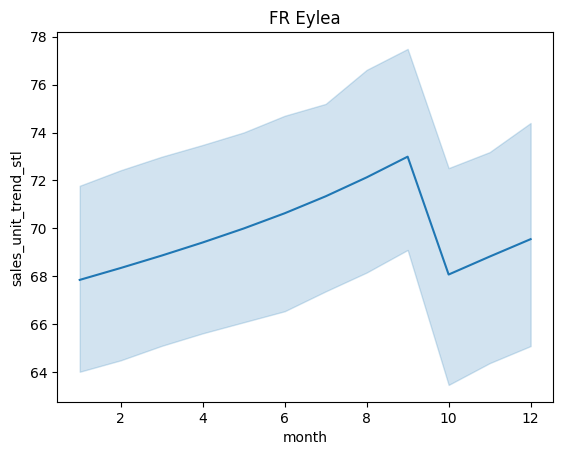

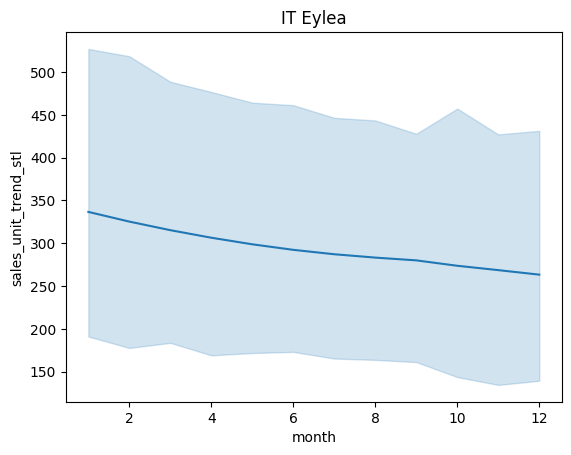

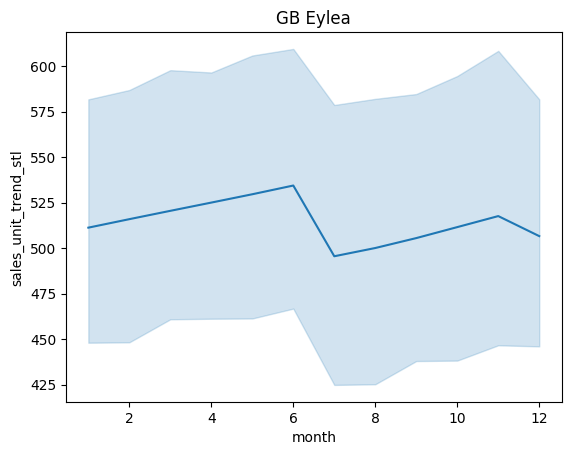

In [14]:
# plot trend

for country in mdb.country_cd.unique():
    for brand in mdb.brand_nm.unique():
        sns.lineplot(data=mdb[(mdb.country_cd==country)&
                              (mdb.brand_nm==brand)], x="month", y="sales_unit_trend_stl")
        plt.title(country+' '+brand)
        plt.show()

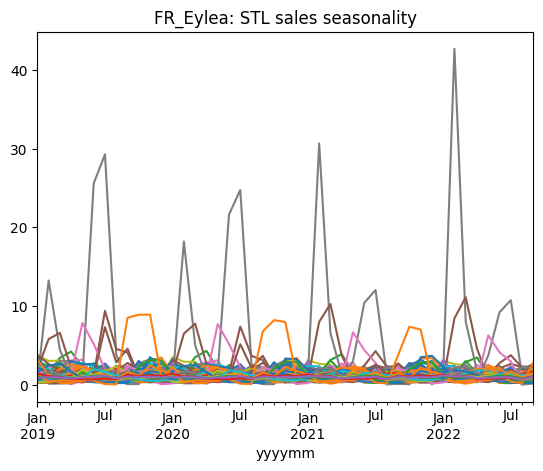

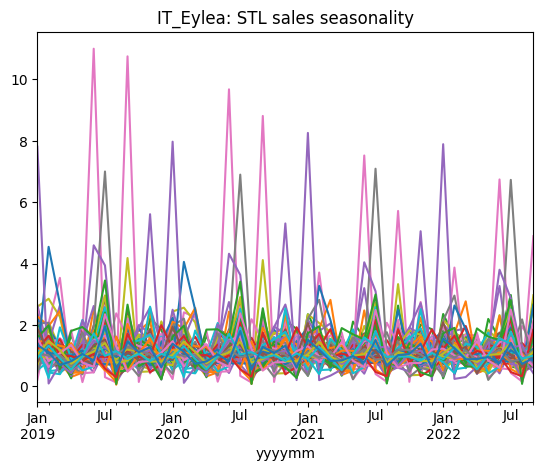

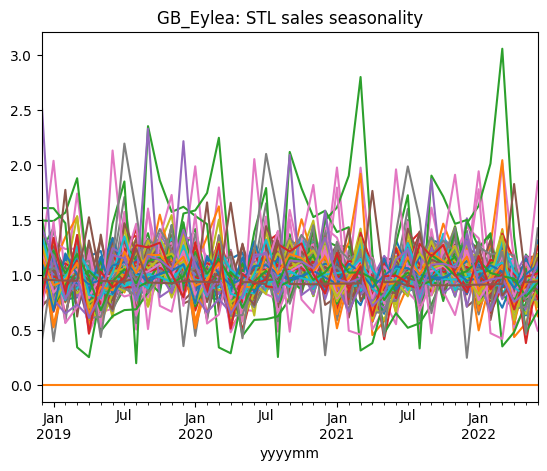

In [15]:
# Plot trend per area:

area = 'cstmr_1_id'
date = 'yyyymm'
target_trend = 'sales_unit_season_stl'

for country in mdb.country_cd.unique():
    for brand in mdb.brand_nm.unique():
        df_temp = mdb[(mdb.country_cd==country)&
                      (mdb.brand_nm==brand)]
        for idx in df_temp.cstmr_1_id.unique():
            df_temp[df_temp.cstmr_1_id==idx].groupby('yyyymm')[target_trend].sum().plot()
            plt.title(country+'_'+brand+': STL sales seasonality')
        plt.show()

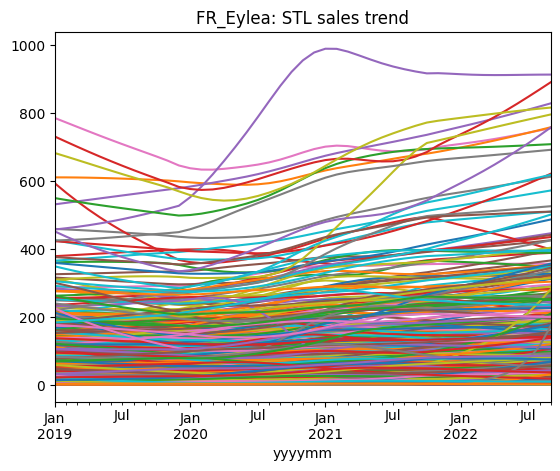

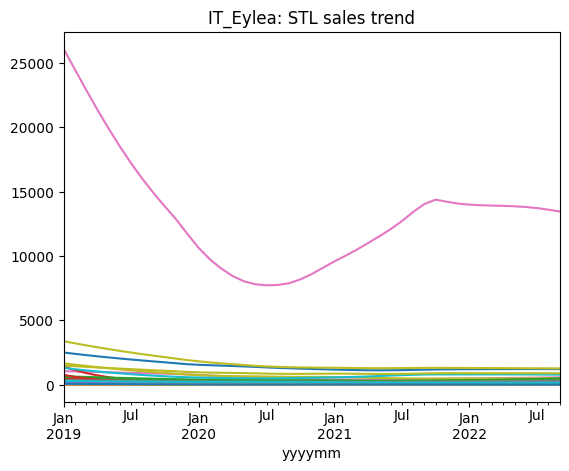

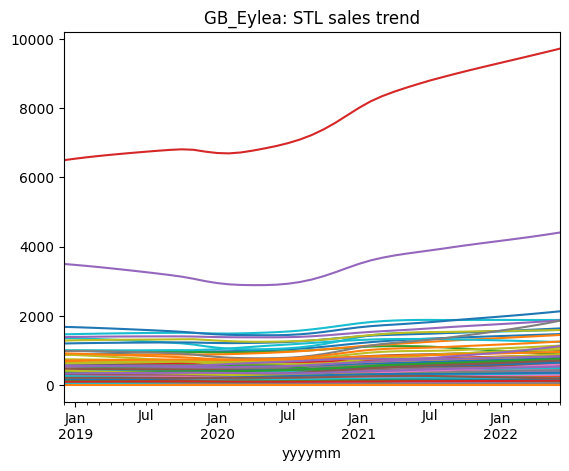

In [16]:
# Plot trend per area:

area = 'cstmr_1_id'
date = 'yyyymm'
target_trend = 'sales_unit_trend_stl'

for country in mdb.country_cd.unique():
    for brand in mdb.brand_nm.unique():
        df_temp = mdb[(mdb.country_cd==country)&
                      (mdb.brand_nm==brand)]
        for idx in df_temp.cstmr_1_id.unique():
            df_temp[df_temp.cstmr_1_id==idx].groupby('yyyymm')[target_trend].sum().plot()
            plt.title(country+'_'+brand+': STL sales trend')
        plt.show()

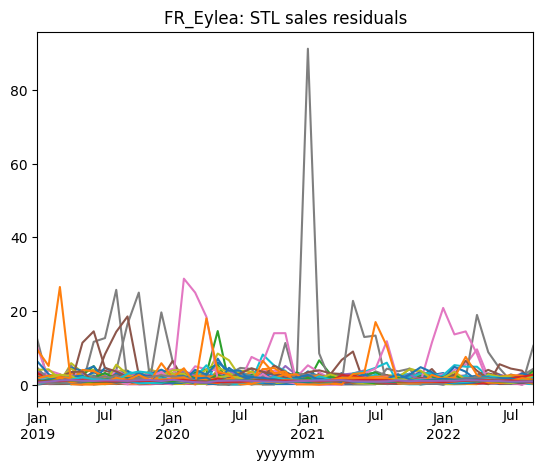

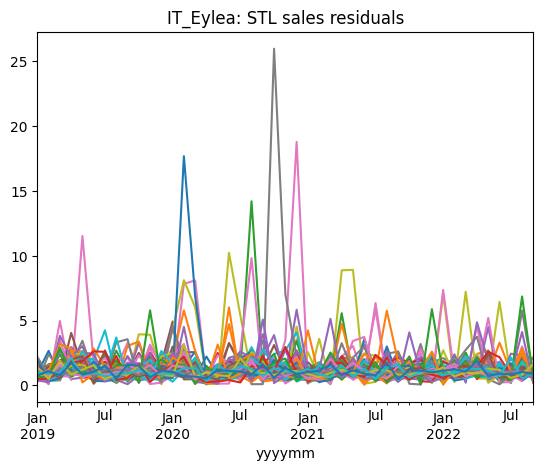

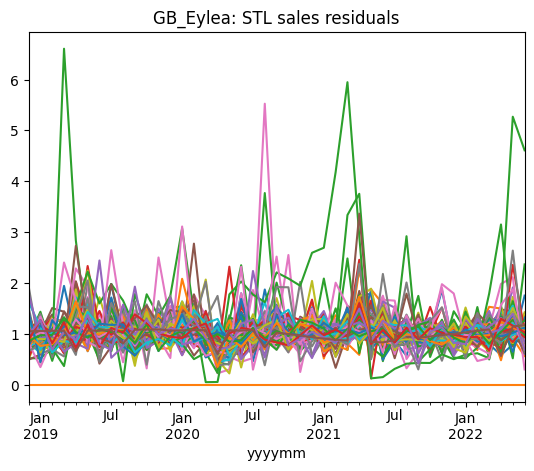

In [17]:
# plot residual per area:

area = 'cstmr_1_id'
date = 'yyyymm'
target_trend = 'sales_unit_detrended_deseasonalized_stl'

for country in mdb.country_cd.unique():
    for brand in mdb.brand_nm.unique():
        df_temp = mdb[(mdb.country_cd==country)&
                      (mdb.brand_nm==brand)]
        for idx in df_temp.cstmr_1_id.unique():
            df_temp[df_temp.cstmr_1_id==idx].groupby('yyyymm')[target_trend].sum().plot()
            plt.title(country+'_'+brand+': STL sales residuals')
        plt.show()

### Number of HCPs as confounder

<Figure size 1000x500 with 0 Axes>

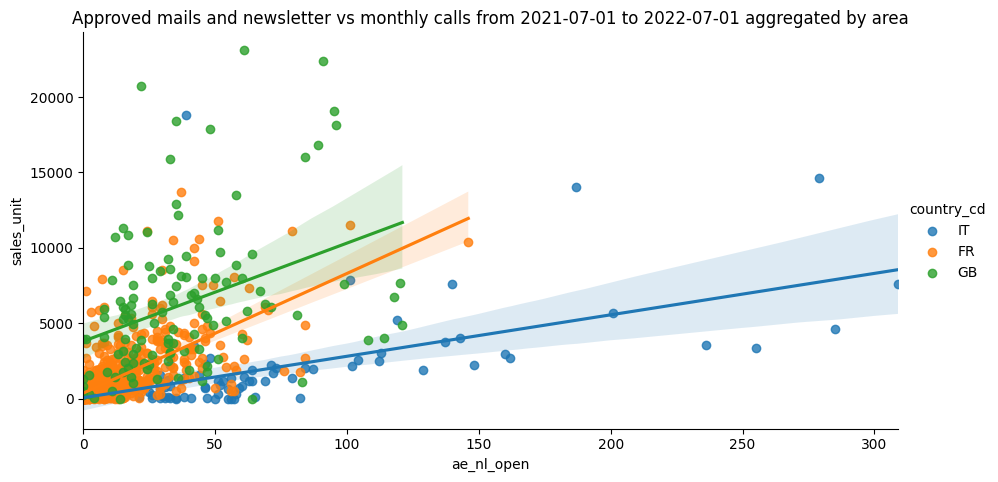

In [18]:
# sales vs ae_nl for each group:

df = mdb[mdb.yyyymm>='2021-07-01'].groupby(['cstmr_1_id','country_cd'])[['total_calls',
                                                                         'total_calls_cph',
                                                                         'ae_nl_open',
                                                                         'sales_unit']].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lmplot(data=df[(df.ae_nl_open<=370)&(df.sales_unit<=30000)], x="ae_nl_open", y="sales_unit", hue="country_cd",height=4.5, aspect=2)
plt.title('Approved mails and newsletter vs monthly calls from 2021-07-01 to 2022-07-01 aggregated by area')
plt.show()

In [19]:
# cleaning and scaling by HCPs:
# forward fill to replace missing hcp count:

mdb = pre_p.replace_missing_hcp_count_ffill(df=mdb,
                                            hcp_variable='total_hcp_cnt',
                                            grouping=['brand_nm','country_cd','cstmr_1_id'],
                                            date='yyyymm') 


# backward fill to replace missing hcp count:

mdb = pre_p.replace_missing_hcp_count_bfill(df=mdb,
                                            hcp_variable='total_hcp_cnt',
                                            grouping=['brand_nm','country_cd','cstmr_1_id'],
                                            date='yyyymm') 


mdb = pre_p.remove_zero(df=mdb, 
                        variable='total_hcp_cnt', 
                        grouping=['brand_nm','country_cd','cstmr_1_id'], 
                        date='yyyymm',
                        min_date='2018-12-01',
                        max_date='2022-09-01',
                        threshold=0)

mdb = pre_p.remove_na(df=mdb,
                      variable='sales_unit',
                      grouping=['brand_nm','country_cd','cstmr_1_id'],
                      date='yyyymm',
                      min_date='2018-12-01',
                      max_date='2022-09-01')

for col in ['ae_nl_open', 'sales_unit']:
    mdb = pre_p.scaling(df=mdb,
                        denominator='total_hcp_cnt', 
                        feature=col) 

<Figure size 1000x500 with 0 Axes>

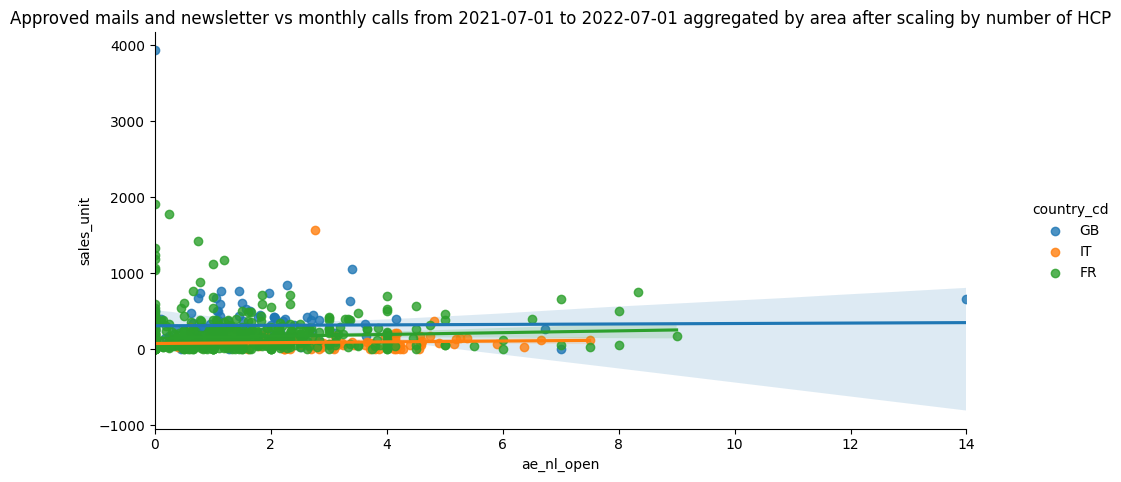

In [20]:
# plot:

df = mdb[mdb.yyyymm>='2021-07-01'].groupby(['cstmr_1_id','country_cd'])[['total_calls',
                                                                         'total_calls_cph',
                                                                         'ae_nl_open',
                                                                         'sales_unit']].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lmplot(data=df, x="ae_nl_open", y="sales_unit", hue="country_cd",height=4.5, aspect=2)
plt.title('Approved mails and newsletter vs monthly calls from 2021-07-01 to 2022-07-01 aggregated by area after scaling by number of HCP')
plt.show()

### Fit OLS

In [4]:
# loading a df with full pre-processing applied:

mdb2 = pd.read_csv('s3a://dsaa-cph-ai-s3-dev/jan_rathfelder/mdb_filtered_without_sondrio_conservative_updated_preprocess_.001zero_stl_sales.csv',
                  low_memory=False)
mdb2 = mdb2[mdb2.cstmr_1_id!='0']

In [5]:
# instantiate classes:

cl = modules.ols_assumptions_check.ols_check(grouping='cstmr_1_id',
                                     time_window='yyyymm')
mc = modules.model_comparison.ModelComparison()

In [6]:
target = 'sales_unit_detrended_deseasonalized_stl'

time_features = [
                 'sales_unit_detrended_deseasonalized_stl_shift1',
                 'sales_unit_detrended_deseasonalized_stl_shift2',
                 'sales_unit_detrended_deseasonalized_stl_shift3',
                 #'sales_unit_detrended_deseasonalized_stl_shift4',
                 #'sales_unit_detrended_deseasonalized_stl_shift5',
                 #'sales_unit_detrended_deseasonalized_stl_shift6',
   
                ]

features=[
    'total_calls_cph_trans_3mean',
    'total_calls_non_cph_trans_3mean',
    'ae_nl_open_cph_trans_3mean',
    'ae_nl_open_non_cph_trans_3mean',
    'evnt_attend_cph_trans_3mean',
    'evnt_attend_non_cph_trans_3mean'
            ]

dates_to_loop_eyl = [
                 ['2021-05-01', '2022-03-01'],
                 ['2021-05-01', '2022-04-01'],
                 ['2021-05-01', '2022-05-01'],
                 ['2021-05-01', '2022-06-01']
                    ] 

dates_to_loop_xrlt = [
                ['2020-05-01', '2022-03-01'],
                 ['2020-05-01', '2022-04-01'],
                ['2020-05-01', '2022-05-01'],
                 ['2020-05-01', '2022-06-01']
                    ] 

                                           OLS Regression Results                                           
Dep. Variable:     sales_unit_detrended_deseasonalized_stl   R-squared (uncentered):                   0.941
Model:                                                 OLS   Adj. R-squared (uncentered):              0.941
Method:                                      Least Squares   F-statistic:                          1.481e+04
Date:                                     Tue, 07 Mar 2023   Prob (F-statistic):                        0.00
Time:                                             13:41:57   Log-Likelihood:                         -275.20
No. Observations:                                     5489   AIC:                                      568.4
Df Residuals:                                         5480   BIC:                                      627.9
Df Model:                                                9                                                  
Covariance Type:   

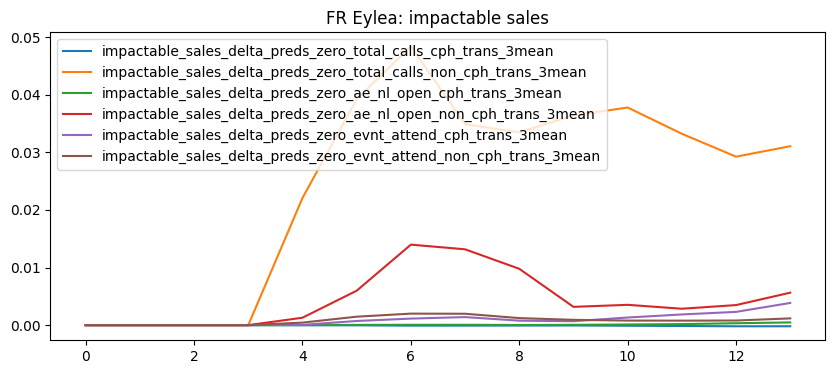

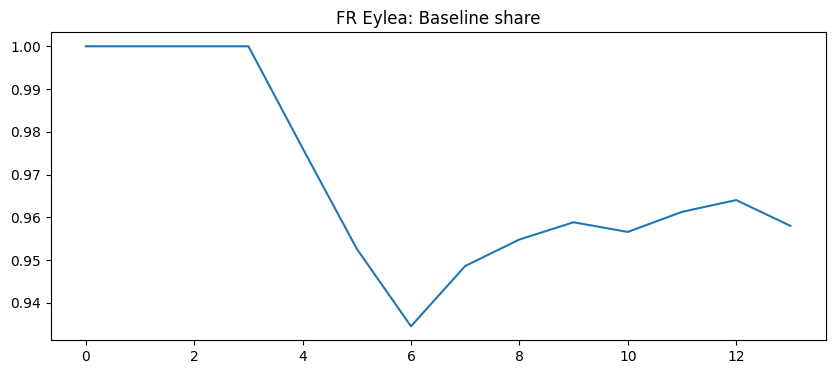

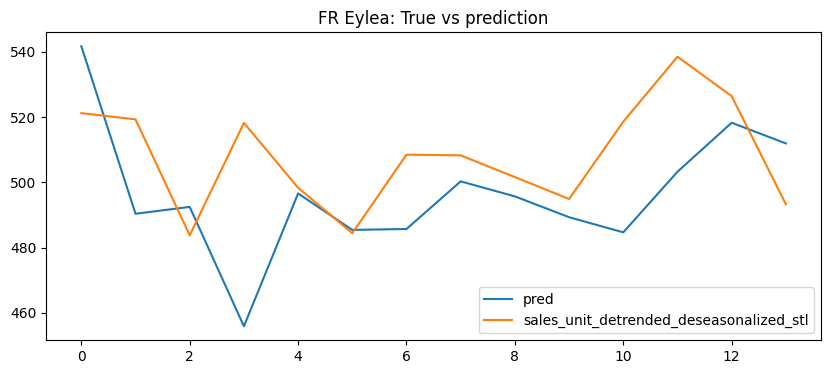

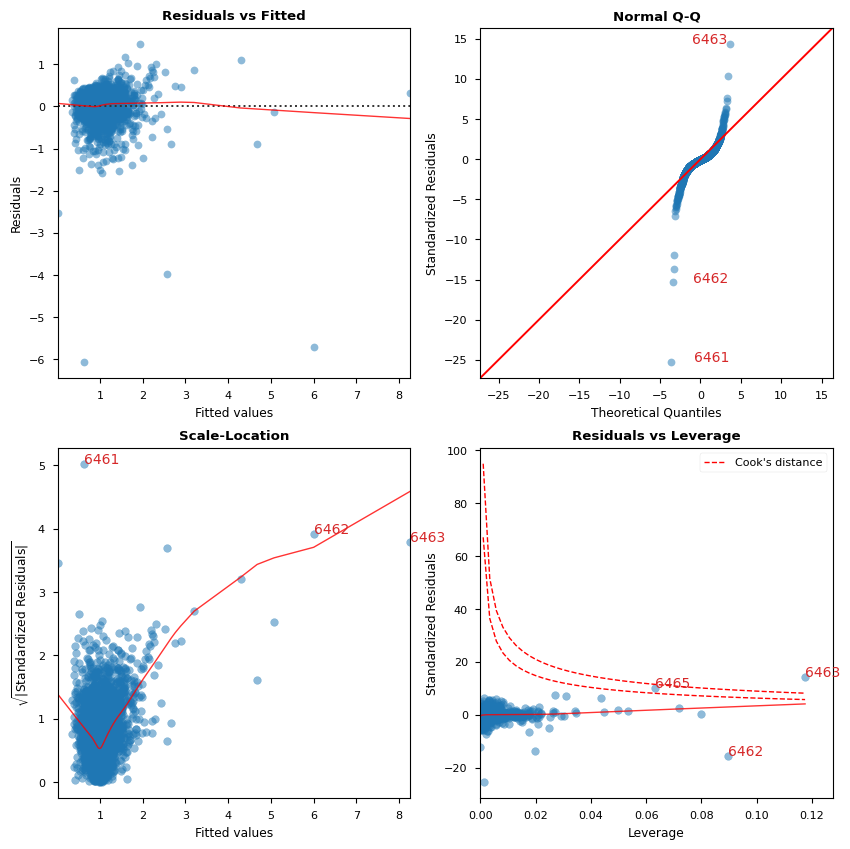

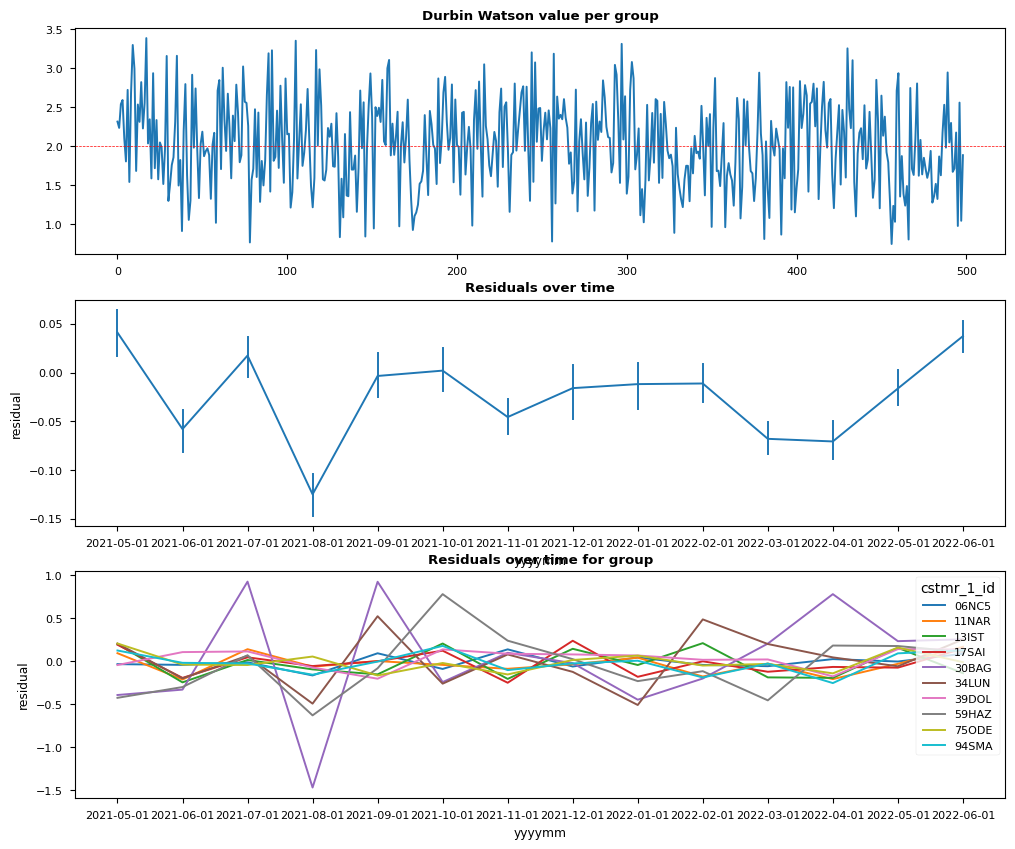

Durbin Watson for pooled sample:1.800882024114595
                                                      vif
ae_nl_open_non_cph_trans_3mean                   1.148469
evnt_attend_cph_trans_3mean                      1.180846
evnt_attend_non_cph_trans_3mean                  1.187853
total_calls_non_cph_trans_3mean                  1.275546
ae_nl_open_cph_trans_3mean                       1.381456
sales_unit_detrended_deseasonalized_stl_shift1   1.481594
sales_unit_detrended_deseasonalized_stl_shift3   1.490450
total_calls_cph_trans_3mean                      1.732238
sales_unit_detrended_deseasonalized_stl_shift2   2.051777
const                                           27.739469


,Features,2022-03-01,2022-04-01,2022-05-01,2022-06-01
0,total_calls_cph_trans_3mean_beta,-1.143628e-01,5.913785e-03,-2.833170e-02,-2.695542e-03
1,total_calls_non_cph_trans_3mean_beta,2.430194e-01,2.623969e-01,2.551675e-01,2.529774e-01
2,ae_nl_open_cph_trans_3mean_beta,2.493461e-01,2.092324e-01,8.979447e-02,2.977963e-03
3,ae_nl_open_non_cph_trans_3mean_beta,3.181154e-01,2.692030e-01,3.070838e-01,2.877608e-01
4,evnt_attend_cph_trans_3mean_beta,6.450023e-01,5.587379e-01,8.384614e-01,3.764497e-01
5,evnt_attend_non_cph_trans_3mean_beta,9.599322e-02,8.011264e-02,1.109130e-01,6.302768e-02
6,sales_unit_detrended_deseasonalized_stl_shift1...,8.380180e-01,8.589102e-01,8.664588e-01,8.684513e-01
7,sales_unit_detrended_deseasonalized_stl_shift2...,-4.256143e-02,-2.039834e-02,-1.709654e-02,-2.239724e-02
8,sales_unit_detrended_deseasonalized_stl_shift3...,1.426024e-01,9.884217e-02,8.793463e-02,9.095320e-02
9,total_calls_cph_trans_3mean_pvalue,5.484434e-01,9.770298e-01,8.356889e-01,9.810494e-01


In [7]:
dfz2 = mc.run_mode_training(df=mdb2,
                            target=target,
                            time_features=time_features,
                            features=features,
                            country='FR',
                            brand='Eylea',
                            area='cstmr_1_id',
                            hcp_scaler='total_hcp_cnt',
                            country_column='country_cd',
                            brand_column='brand_nm',
                            date_column='yyyymm',
                            dates_to_loop=dates_to_loop_eyl,
                            selected_algo='ols_positive_',
                            trend_variable='trend_season_stl',
                            show_classic_model_diagnostics=1,
                            show_additional_model_diagnostics=1,
                            show_summary_plots=1,
                            show_vif=1,
                            constant=0,
                            area_dummy=0)
display(dfz2)

### Equations used in ppt

$y_{t} = \sum_{s=0}^{\inf} \alpha_{s} y_{t-s} + \sum_{j=0}^{\inf} \beta_{j} x_{t-j}$

$y_t = \alpha_{y} *  y_{t-1} + \beta_{ae\_nl} * ae\_nl_{3\_months} + beta_{calls} * calls_{3\_months} + beta_{events} * events_{3\_months}$